In [2]:
%matplotlib inline
import csv, os, matplotlib, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy import spatial, stats
from sklearn import metrics

In [3]:
# This file consists of titles and release years associated with each ID
movie_titles = pd.read_csv('data/COS424_hw3/movie_titles.txt', header = None, names = ['ID','Year','Name'])
# print(movie_titles.head())
print(movie_titles.shape)

movie_by_id = {}
for id, name, year in zip(movie_titles['ID'], movie_titles['Name'], movie_titles['Year']):
    if not (np.isnan(year)):
        year = str(int(year))
    else:
        year = 'NaN'
    movie_by_id[id] = name + ' ' + '(' + year + ')'
    
# import the movie genre data scraped using imdbpy
movie_genres = pd.read_csv('data/onehot_all_movie_genres.csv', header = 0)
print(movie_genres.shape)

# This file is a sparse matrix of movies by user, with each element a rating (1-5) or nonresponse (0)
ratings_csr = sparse.load_npz('data/COS424_hw3/netflix_full_csr.npz')
print(ratings_csr.shape)

# Filter the matrix to remove rows with NO REVIEWS
start = time.time()
ratings_csc = ratings_csr.T
print 'before removing users with no reviews: ', ratings_csc.shape
non_zero_users_csc = ratings_csc[(ratings_csc.getnnz(axis=1) != 0)]
print non_zero_users_csc.shape
finish = time.time()
print 'finished in %.2f seconds' % (finish - start)

# construct a dictionary to store number of reviews per user
print non_zero_users_csc.shape
non_zero_users_csr = csr_matrix(non_zero_users_csc)
reviews_by_user = {}
for u in range(non_zero_users_csr.shape[0]):
    reviews_by_user[u] = non_zero_users_csr[u].nnz

# count the number of reviews for each film and store in review_nums list
reviews_by_movie = {}
csc_t = non_zero_users_csc.transpose()
for i in range(1, csc_t.shape[0]):
    movie_col = csc_t[i]
    num_reviews = movie_col.nnz
    reviews_by_movie[i] = {
        'num_reviews': num_reviews,
        'avg_review': movie_col.sum() / num_reviews
    }

(17770, 3)
(17770, 28)
(17771, 2649430)
before removing users with no reviews:  (2649430, 17771)
(480189, 17771)
finished in 29.55 seconds
(480189, 17771)


In [152]:
def merge_dicts(d1, d2):
    d = d1.copy()
    d.update(d2)
    return d

ada_boost_results = {}
linear_regression_results = {}
random_forest_results = {}
ridge_results = {}
cluster_means_results = {}
user_avg_results = {}

for i in range(11):
    with open('pickle/linear_regression_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        linear_regression_results = merge_dicts(linear_regression_results, d)
        
for i in range(10):
    with open('pickle/ridge_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        ridge_results = merge_dicts(ridge_results, d)
        
for i in range(11):
    with open('pickle/ada_boost_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        ada_boost_results = merge_dicts(ada_boost_results, d)
        
for i in range(11):
    with open('pickle/random_forest_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        random_forest_results = merge_dicts(random_forest_results, d)

for i in range(10):
    with open('pickle/vanilla_cluster_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        print len(d.keys())
        cluster_means_results = merge_dicts(cluster_means_results, d)
print
for i in range(10):
    with open('pickle/final_cluster_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        print len(d.keys())
        user_avg_results = merge_dicts(user_avg_results, d)

1800
1800
1800
1800
1800
1800
1800
1800
1800
1570

1800
1800
1800
1800
1800
1800
1800
1800
1800
1570


17770 movies in Linear Regression dict

r2
0.779	Leprechaun 3 (1995)
0.756	The Andy Griffith Show: Vol 5: Rafe Hollister Sings / Class Reunion (1963)
0.745	Dragon Ball: Fortune Teller Baba Saga (2002)
0.739	Silent Rage (1982)
0.716	Texas Chainsaw Massacre: The Next Generation (1994)
0.715	Cadfael: A Morbid Taste for Bones (1996)
0.715	Xena: Warrior Princess: Season 6 (2000)
0.713	The Andy Griffith Show: Vol 4: The Mountain Wedding / Opie and the Spoiled Child (1963)
0.713	The Andy Griffith Show: Vol 2: The Big House / A Wife for Andy (1963)
0.711	Cadfael: The Holy Thief (1998)

average r2 value: -0.11

MSE
0.085	Larryboy and the Rumor Weed (1999)
0.135	Ah! My Goddess (2005)
0.214	Sword of the Beast (1965)
0.248	Cadfael: A Morbid Taste for Bones (1996)
0.252	1969 (1988)
0.263	Cadfael: The Potter's Field (1998)
0.273	Avia Vampire Hunter (2005)
0.275	Dune: Extended Edition (1984)
0.288	Cadfael: The Sanctuary Sparrow (1994)
0.302	Inspector Morse 13: The Sins of the Father (1990)

average M

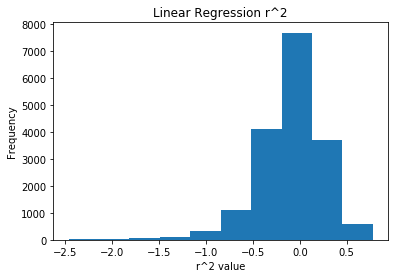

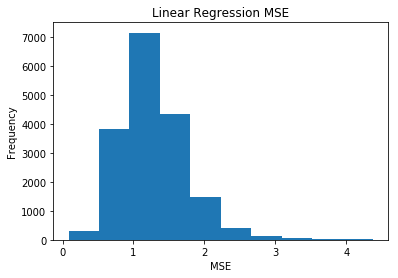

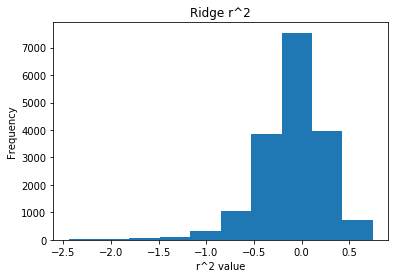

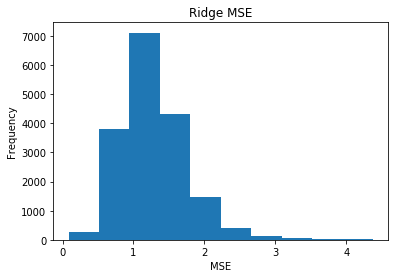

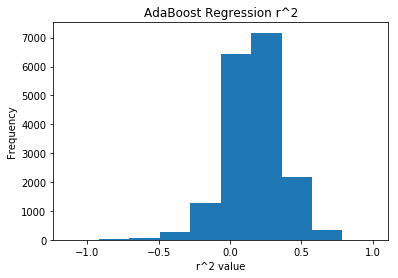

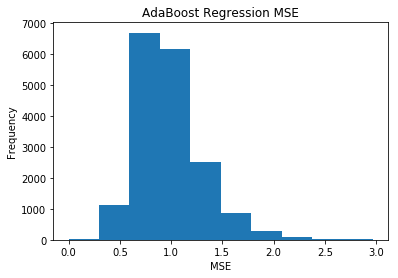

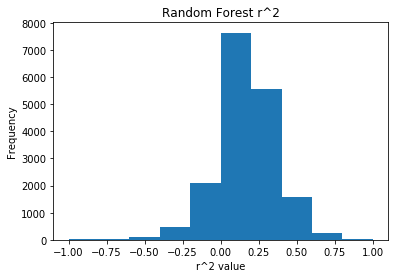

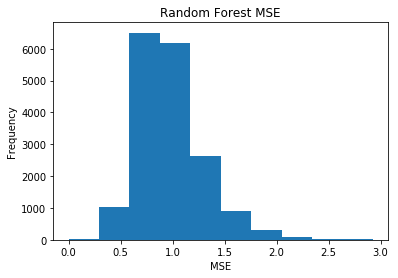

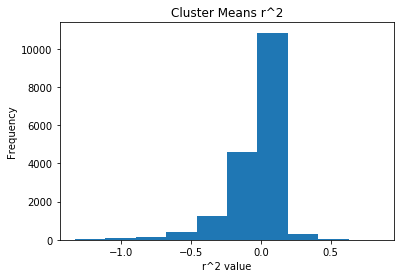

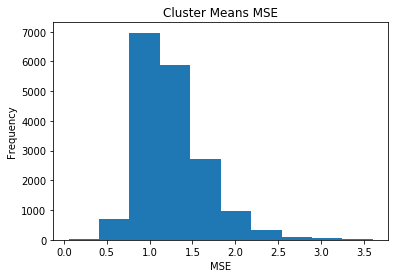

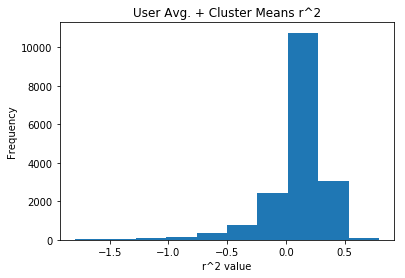

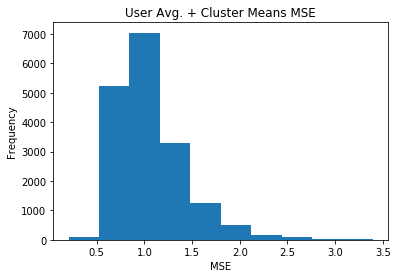

In [153]:
# cursory analytics
def average_nested_dict_key(d, k):
    sum = np.sum([d[i][k] for i in sorted(d.keys())])
    return sum / len(d.keys())

def list_nested_dict_key(d, k):
    return [d[i][k] for i in sorted(d.keys())]

def reject_outliers(data, m=6):
    data = np.array(data)
    return data[abs(data - np.mean(data)) < m * np.std(data)], np.where(abs(data - np.mean(data)) < m * np.std(data))

result_dicts = [
    linear_regression_results,
    ridge_results,
    ada_boost_results,
    random_forest_results,
    cluster_means_results,
    user_avg_results
]
result_names = [
    'Linear Regression',
    'Ridge',
    'AdaBoost Regression',
    'Random Forest',
    'Cluster Means',
    'User Avg. + Cluster Means'
]

for results, name in zip(result_dicts, result_names):
    print '%d movies in %s dict' % (len(results.keys()), name)
    print

    ks = results.keys()
    # sort by r2 value
    print 'r2'
    s = sorted(ks, key=lambda x: results[x]['r2'], reverse=True)
    for i in s[:10]:
        print '%.3f\t%s' % (results[i]['r2'], results[i]['name'])

    print
    print 'average r2 value: %.2f' % average_nested_dict_key(results, 'r2')
    
    r2_plot = plt.figure()
    r2_ax = r2_plot.add_subplot(1, 1, 1)
    n, bins, patches = r2_ax.hist(reject_outliers(list_nested_dict_key(results, 'r2'))[0])
    r2_ax.set_xlabel('r^2 value')
    r2_ax.set_ylabel('Frequency')
    r2_ax.set_title(name + ' r^2')
    r2_plot.show()
    
    # sort by mse
    print '\nMSE'
    s = sorted(ks, key=lambda x: results[x]['mse'])
    for i in s[:10]:
        print '%.3f\t%s' % (results[i]['mse'], results[i]['name'])

    print
    print 'average MSE value: %.2f' % average_nested_dict_key(results, 'mse')
    
    mse_plot = plt.figure()
    mse_ax = mse_plot.add_subplot(1, 1, 1)
    n, bins, patches = mse_ax.hist(reject_outliers(list_nested_dict_key(results, 'mse'))[0])
    mse_ax.set_xlabel('MSE')
    mse_ax.set_ylabel('Frequency')
    mse_ax.set_title(name + ' MSE')
    mse_plot.show()
    
    print '\n'

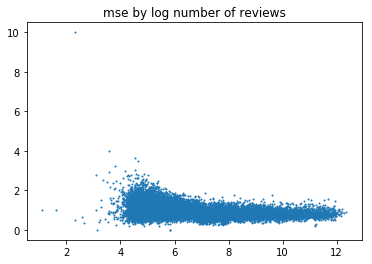

In [215]:
results = random_forest_results
scatter = plt.figure()
x = np.log(list_nested_dict_key(reviews_by_movie, 'num_reviews'))
y = list_nested_dict_key(results, 'mse')
plt.scatter(x, y, s=1)
plt.title('mse by log number of reviews')
scatter.show()

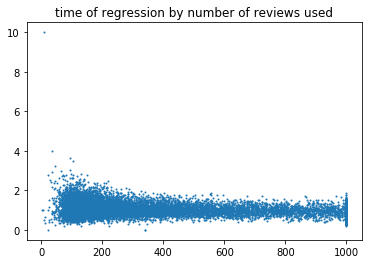

In [216]:
scatter = plt.figure()
x = [min(1000, i) for i in list_nested_dict_key(reviews_by_movie, 'num_reviews')]
y1 = np.array(list_nested_dict_key(results, 'data_time')) + np.array(list_nested_dict_key(results, 'regr_time'))
plt.scatter(x, y, s=1)
plt.title('time of regression by number of reviews used')
scatter.show()

DescribeResult(nobs=17722, minmax=(0.47693872451782227, 16.24394989013672), mean=1.2077885971369613, variance=0.27416107526489586, skewness=12.285784469363657, kurtosis=289.7518986242024)


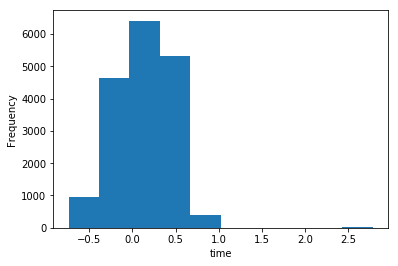

In [25]:
results = linear_regression_results
times = np.array(list_nested_dict_key(results, 'data_time')) + np.array(list_nested_dict_key(results, 'regr_time'))

print stats.describe(reject_outliers(times)[0])

time_plot = plt.figure()
ax1 = time_plot.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(np.log(reject_outliers(times)[0]))
ax1.set_xlabel('time')
ax1.set_ylabel('Frequency')
time_plot.show()

In [40]:
# weight results per REVIEW, not per move
results = user_avg_results

values = np.array(list_nested_dict_key(results, 'r2'))
weights = np.array(list_nested_dict_key(reviews_by_movie, 'num_reviews'))[:17700]
weighted = np.average(values, weights=weights)

print weighted

0.10303138950126206


In [48]:
len(ridge_results.keys())

17700

In [63]:
sum(np.array(list_nested_dict_key(reviews_by_movie, 'num_reviews')) > 15000)

1563

In [62]:
len(cluster_means_results.keys())

71

In [61]:
cluster_means_results = {}
for i in range(10,11):
    with open('pickle/cluster_means_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        cluster_means_results = merge_dicts(cluster_means_results, d)

In [127]:
len(user_avg_results.keys())

17770

In [178]:
result_dicts = [
    linear_regression_results,
    ridge_results,
    ada_boost_results,
    random_forest_results,
    cluster_means_results,
    user_avg_results
]
result_names = [
    'Linear Regression',
    'Ridge',
    'AdaBoost Regression',
    'Random Forest',
    'Cluster Means',
    'User Avg. Factor With Cluster Means'
]

def summary(arr):
    return np.min(arr), np.max(arr), np.median(arr), np.mean(arr), np.percentile(arr, 25), np.percentile(arr, 75) 

for results, name in zip(result_dicts, result_names):
    print name
    for i, j in zip('min', 'max', 'median', 'mean', '25th', '75th')
    print summary(np.array(list_nested_dict_key(results, 'regr_time')))
    print

Linear Regression
(0.003370046615600586, 70.94864296913147, 0.20702064037322998, 0.3480372659128304, 0.09499841928482056, 0.35004526376724243)

Ridge
(0.00292205810546875, 3.40974497795105, 0.4516359567642212, 0.5189214622502947, 0.21107697486877441, 0.7220569849014282)

AdaBoost Regression
(0.003553152084350586, 183.63628602027893, 17.349790573120117, 20.24557638945174, 5.176977217197418, 28.245585203170776)

Random Forest
(0.002334117889404297, 80.27784705162048, 14.232710838317871, 15.909695095055278, 4.6018372774124146, 25.12695002555847)

Cluster Means
(0.00034999847412109375, 44.308669090270996, 0.003720998764038086, 0.24414763364754302, 0.0013229846954345703, 0.03563803434371948)

User Avg. Factor With Cluster Means
(0.0008649826049804688, 39.12267088890076, 0.0863415002822876, 0.5346709193442736, 0.017962276935577393, 0.274746835231781)



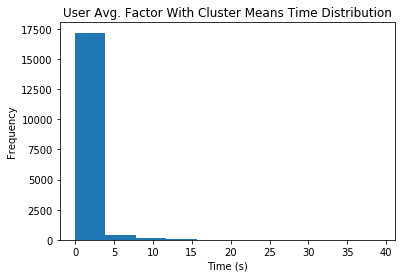

In [176]:
for results, name in zip(result_dicts, result_names): 
    plt.clf()
    r2_plot = plt.figure()
    r2_ax = r2_plot.add_subplot(1, 1, 1)
    data = np.array(list_nested_dict_key(results, 'regr_time'))
    
    n, bins, patches = r2_ax.hist(data)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('%s Time Distribution' % name)
    r2_plot.show()
    r2_plot.savefig('results/%s_time_dist.png' % name.split()[0])

In [158]:
print len(random_forest_results.keys())

17770


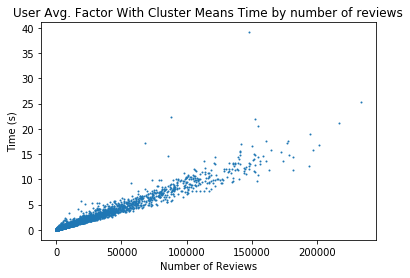

In [177]:
for results, name in zip(result_dicts, result_names): 
    plt.clf()
    scatter = plt.figure()
    lim = 17770 if name != 'Ridge' else 17700
    x = list_nested_dict_key(reviews_by_movie, 'num_reviews')[:lim]
    
    y = list_nested_dict_key(results, 'regr_time')
    plt.scatter(x, y, s=1)
    #plt.ylim(ymax=5)
    plt.title('%s Time by number of reviews' % name)
    plt.xlabel('Number of Reviews')
    plt.ylabel('Time (s)')
    scatter.show()
    plt.savefig('results/%s_time_reviews.png' % name.split()[0])

In [162]:
for i, j in zip(result_dicts, result_names):
    print j, len(i.keys())

Linear Regression 17770
Ridge 17700
AdaBoost Regression 17770
Random Forest 17770
Cluster Means 17770
User Avg. Factor With Cluster Means 17770
